In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
df = pd.read_csv('ETH_REDDIT_SENTIMENT.csv')

In [3]:
df.shape

(2780, 16)

In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
df.set_index('date',inplace=True)

In [6]:
df.sort_values(by='date',inplace=True)

In [7]:
dataset = df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
num_of_features = len(df.columns)
print('Number of features', num_of_features)

Number of features 14


In [8]:
expr_name = 'expr_2'
look_back = 24*7 
lstm_layers = 32
epochs=10
batch_size=128

In [9]:
train_size_percent = 0.75
pred_col = df.columns.get_loc('close')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, pred_col])
    return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  2085
Testing dataset length  695
look_back  168


In [10]:
model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
ETH = model.fit(trainX, trainY,validation_split=0.25, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/10
12/12 [==============================] - 3s 190ms/step - loss: 0.2691 - val_loss: 0.0150
Epoch 2/10
12/12 [==============================] - 1s 122ms/step - loss: 0.0543 - val_loss: 0.0365
Epoch 3/10
12/12 [==============================] - 1s 115ms/step - loss: 0.0157 - val_loss: 0.0057
Epoch 4/10
12/12 [==============================] - 1s 118ms/step - loss: 0.0148 - val_loss: 0.0043
Epoch 5/10
12/12 [==============================] - 1s 113ms/step - loss: 0.0087 - val_loss: 0.0045
Epoch 6/10
12/12 [==============================] - 1s 112ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 7/10
12/12 [==============================] - 1s 119ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 8/10
12/12 [==============================] - 1s 121ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 9/10
12/12 [==============================] - 1s 119ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 10/10
12/12 [==============================] - 1s 116ms/step - loss: 0.0015 - val_loss: 0.0031

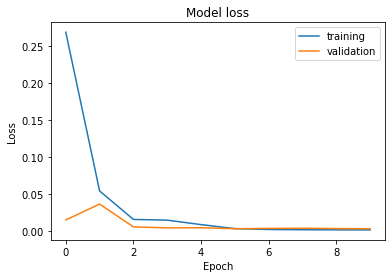

In [11]:
# Plot training
plt.plot(ETH.history['loss'])
plt.plot(ETH.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [12]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

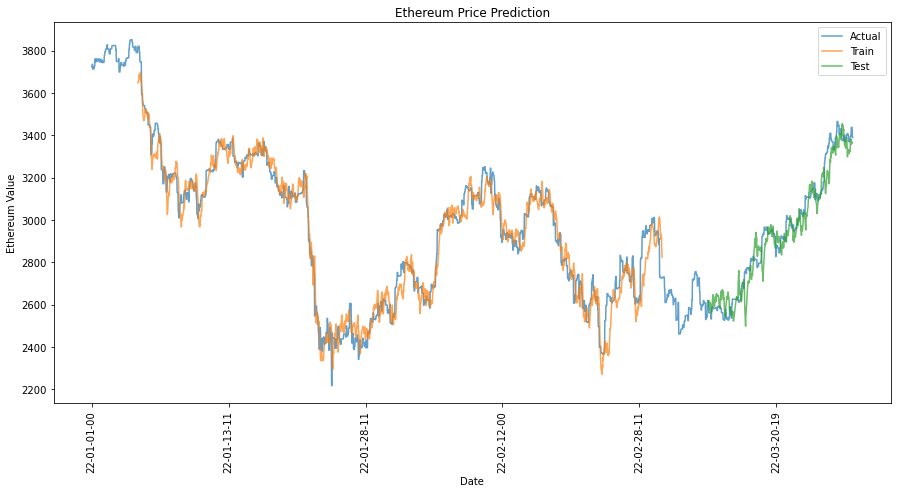

In [13]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=True)
time_df2.set_index('date',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Ethereum Value')
plt.title('Ethereum Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [14]:
print('-' * 100)
print('Experiment name:', expr_name)
print('-' * 100)
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(df.columns))
print('-' * 100)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))
print('-' * 100)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))
print('-' * 100)
print('Model summary:')
model.summary()

----------------------------------------------------------------------------------------------------
Experiment name: expr_2
----------------------------------------------------------------------------------------------------
look_back days: 7.0
lstm_layers: 32
epochs: 10
batch_size: 128
dataset features ['Reddit_Flair', 'Reddit_TB_Polarity', 'Reddit_TB_Subjectivity', 'Reddit_Vader_Pos', 'Reddit_Vader_Neg', 'Reddit_Vader_Neu', 'Reddit_Vader_Compound', 'open', 'high', 'low', 'close', 'Volume ETH', 'Volume USDT', 'tradecount']
----------------------------------------------------------------------------------------------------
Train Score: 70.70 RMSE
Test Score: 69.78 RMSE
----------------------------------------------------------------------------------------------------
Train Score: 52.83 MAE
Test Score: 54.39 MAE
----------------------------------------------------------------------------------------------------
Model summary:
Model: "sequential"
_______________________________________